In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

from tensorflow import keras
from tensorflow.keras import layers

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
batch_size = 64
num_channels = 1
num_classes = 10
image_size = 28
latent_dim = 128

In [3]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
all_digits = np.concatenate([x_train, x_test])
all_labels = np.concatenate([y_train, y_test])

# Normalize data
all_digits = all_digits.astype("float32") / 255.0
# Add a channel dimension
all_digits = np.reshape(all_digits, (-1, image_size, image_size, 1))
all_labels = keras.utils.to_categorical(all_labels, num_classes)


dataset = tf.data.Dataset.from_tensor_slices((all_digits, all_labels))
dataset = dataset.shuffle(buffer_size=1024).batch(batch_size)

print(f"Shape of training images: {all_digits.shape}")
print(f"Shape of training labels: {all_labels.shape}")

Shape of training images: (70000, 28, 28, 1)
Shape of training labels: (70000, 10)


In [4]:
generator_in_channels = latent_dim + num_classes # number of input channels for generator
discriminator_in_channels = num_channels + num_classes # number of input channels for discriminator

print(f"Generator input channels: {generator_in_channels}")
print(f"Discriminator input channels: {discriminator_in_channels}")

Generator input channels: 138
Discriminator input channels: 11


In [5]:
discriminator = keras.Sequential(
    [
        keras.layers.InputLayer((28,28,discriminator_in_channels)),
        keras.layers.Conv2D(64, kernel_size=(3,3), strides=(2,2), padding='same'),
        keras.layers.LeakyReLU(alpha=0.2),
        keras.layers.Conv2D(128, kernel_size=(3,3), strides=(2,2), padding='same'),
        keras.layers.LeakyReLU(alpha=0.2),
        keras.layers.GlobalMaxPooling2D(),
        keras.layers.Dense(1),
    ],
    name="discriminator",
)

In [6]:
generator = keras.Sequential(
    [
        keras.layers.InputLayer((generator_in_channels,)),
        keras.layers.Dense(7 * 7 * generator_in_channels),
        keras.layers.LeakyReLU(alpha=0.2),
        keras.layers.Reshape((7, 7, generator_in_channels)),
        keras.layers.Conv2DTranspose(128, kernel_size=(4,4), strides=(2,2), padding='same'),
        keras.layers.LeakyReLU(alpha=0.2),
        keras.layers.Conv2DTranspose(128, kernel_size=(4,4), strides=(2,2), padding='same'),
        keras.layers.LeakyReLU(alpha=0.2),
        keras.layers.Conv2D(1, kernel_size=(7,7), padding='same', activation='sigmoid'),
    ],
    name="generator",
)

In [9]:
class CGAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.gen_loss_tracker = keras.metrics.Mean(name="generator_loss")
        self.disc_loss_tracker = keras.metrics.Mean(name="discriminator_loss")

    @property
    def metrics(self):
        return [self.gen_loss_tracker, self.disc_loss_tracker]

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super().compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
    
    def train_step(self, data):
        real_images, one_hot_labels = data

        image_one_hot_labels = one_hot_labels[:,:,None,None]
        image_one_hot_labels = tf.repeat(image_one_hot_labels, repeats=[image_size*image_size])
        image_one_hot_labels = tf.reshape(image_one_hot_labels, (-1, image_size, image_size, num_classes))

        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        random_latent_vectors = tf.concat([random_latent_vectors, one_hot_labels], axis=-1)

        generated_images = self.generator(random_latent_vectors)

        fake_image_and_labels = tf.concat([generated_images, image_one_hot_labels], axis=-1)
        real_image_and_labels = tf.concat([real_images, image_one_hot_labels], axis=-1)

        combined_images = tf.concat([fake_image_and_labels, real_image_and_labels], axis=0)

        labels = tf.concat([tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0)

        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(zip(grads, self.discriminator.trainable_weights))

        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        random_vector_labels = tf.concat([random_latent_vectors, one_hot_labels], axis=-1)

        misleading_labels = tf.zeros((batch_size, 1))

        with tf.GradientTape() as tape:
            fake_images = self.generator(random_vector_labels)
            fake_image_and_labels = tf.concat([fake_images, image_one_hot_labels], axis=-1)
            predictions = self.discriminator(fake_image_and_labels)
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        self.gen_loss_tracker.update_state(g_loss)
        self.disc_loss_tracker.update_state(d_loss)

        return {"g_loss": self.gen_loss_tracker.result(), "d_loss": self.disc_loss_tracker.result()}


In [12]:
cgan = CGAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)

cgan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0003),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0003),
    loss_fn=keras.losses.BinaryCrossentropy(from_logits=True),
)

cgan.fit(dataset, epochs=20)

Epoch 1/20
1094/1094 [==============================] - 87s 68ms/step - g_loss: 1.3474 - d_loss: 0.4557
Epoch 2/20
1094/1094 [==============================] - 73s 67ms/step - g_loss: 1.3365 - d_loss: 0.4836
Epoch 3/20
1094/1094 [==============================] - 72s 66ms/step - g_loss: 1.4885 - d_loss: 0.4282
Epoch 4/20
1094/1094 [==============================] - 73s 67ms/step - g_loss: 2.0922 - d_loss: 0.2491
Epoch 5/20
1094/1094 [==============================] - 74s 67ms/step - g_loss: 1.9443 - d_loss: 0.3596
Epoch 6/20
1094/1094 [==============================] - 73s 67ms/step - g_loss: 0.9428 - d_loss: 0.6477
Epoch 7/20
1094/1094 [==============================] - 73s 67ms/step - g_loss: 0.8621 - d_loss: 0.6666
Epoch 8/20
1094/1094 [==============================] - 73s 66ms/step - g_loss: 0.8079 - d_loss: 0.6829
Epoch 9/20
1094/1094 [==============================] - 72s 66ms/step - g_loss: 0.7699 - d_loss: 0.6893
Epoch 10/20
1094/1094 [==============================] - 73s 66m

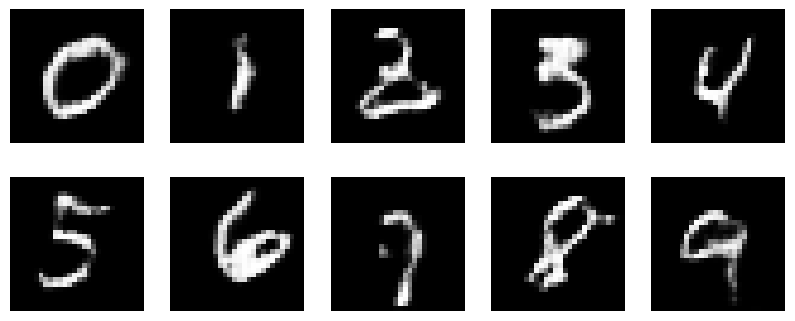

In [17]:
num_samples = 10
trained_generator = cgan.generator

random_latent_vectors = tf.random.normal(shape=(num_samples, latent_dim))
labels = tf.one_hot([0,1,2,3,4,5,6,7,8,9], num_classes)

random_latent_vectors = tf.concat([random_latent_vectors, labels], axis=-1)

generated_images = trained_generator(random_latent_vectors)

# plot in a grid 2x5
fig = plt.figure(figsize=(10,4))
for i in range(num_samples):
    plt.subplot(2, 5, i+1)
    plt.imshow(generated_images[i, :, :, 0], cmap='gray')
    plt.axis('off')
plt.show()